# Recovering time-independent Hamiltonian from the wavefunction as a function of time

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from split_op_schrodinger1D import SplitOpSchrodinger1D
from imag_time_propagation import ImgTimePropagation
from recovering_hamiltonian import RecoverHamiltonian

In [2]:
# Changing the default size of all the figures 
plt.rcParams['figure.figsize'] = [15, 8]

# Use the evolution generated by the time-independent Hamiltonian as input

## propagate to get the input

In [112]:
# parameters of the quantum system to be studied
@njit
def v(x, t=0.):
    """
    Potential energy
    """
    return 0.02 * x ** 4
    
@njit
def k(p, t=0.):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2

quant_sys_params = dict(
    dt = 0.008,
    x_grid_dim=512,
    x_amplitude=10.,
    k=k,
    v=v,
)

In [113]:
# initialize the propagator
quant_sys = SplitOpSchrodinger1D(**quant_sys_params)

# set the initial condition that is not an eigenstate
quant_sys.set_wavefunction(
    lambda x: np.exp(-0.4 * (x + 2.5) ** 2)
)

# Save the evolution
wavefunctions = [quant_sys.propagate().copy() for _ in range(10000)]
wavefunctions = np.array(wavefunctions)



## Reconstruct Hamiltonian

In [114]:
reconstructed_h = RecoverHamiltonian(wavefunctions, dt=quant_sys.dt)
times = quant_sys.dt * np.arange(len(wavefunctions))
reconstructed_wavefunctions = reconstructed_h.propagate(times)

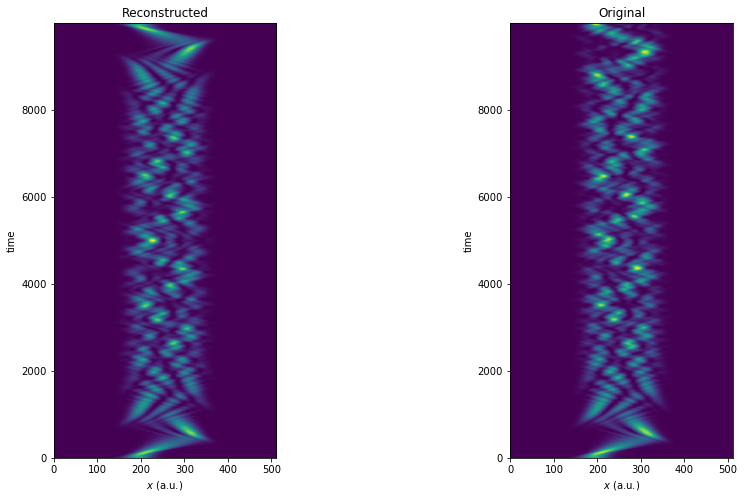

In [115]:
plt.subplot(121)

plt.title('Reconstructed')
plt.imshow(np.abs(reconstructed_wavefunctions) ** 2, origin='lower', aspect=0.1)

plt.xlabel('$x$ (a.u.)')
plt.ylabel('time')

plt.subplot(122)
plt.title('Original')
plt.imshow(np.abs(wavefunctions) ** 2, origin='lower', aspect=0.1)

plt.xlabel('$x$ (a.u.)')
plt.ylabel('time')

plt.show()

In [116]:
reconstructed_h.energies

array([ 0.15707963,  0.62831853,  1.25663706,  1.96349541,  2.74889357,
        3.61283155,  4.55530935,  5.49778714,  6.51880476,  7.53982237,
        8.56083998,  9.73893723, 10.83849465, 12.0165919 ])

# Use the evolution generated by the time-independent Hamiltonian as input

## propagate to get the input

In [166]:
# parameters of the quantum system to be studied

# the number of time steps
num_time_steps = 10000
dt = 0.008

@njit
def v(x, t=0.):
    """
    Potential energy
    """
    #return 0.02 * x ** 4 + 0.0 * x * np.sin(2 * np.pi * t / (0.25 * num_time_steps * dt))
    return 0.01 * (1. - 0.95 / (1. + np.exp(-0.5 * t))) * x ** 4

@njit
def k(p, t=0.):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2

quant_sys_params = dict(
    dt = dt,
    x_grid_dim=512,
    x_amplitude=10.,
    k=k,
    v=v,
)

In [167]:
# initialize the propagator
quant_sys = ImgTimePropagation(**quant_sys_params)

# set the initial condition that is the grorund state
quant_sys.set_wavefunction(
    quant_sys.get_stationary_states(1).stationary_states[0]
)

# Save the evolution
wavefunctions = [quant_sys.propagate().copy() for _ in range(num_time_steps)]
wavefunctions = np.array(wavefunctions)

times = quant_sys.dt * np.arange(num_time_steps)

## Reconstruct Hamiltonian

In [168]:
reconstructed_h = RecoverHamiltonian(wavefunctions, dt=quant_sys.dt, threshold=1e-3)
reconstructed_wavefunctions = reconstructed_h.propagate(times)

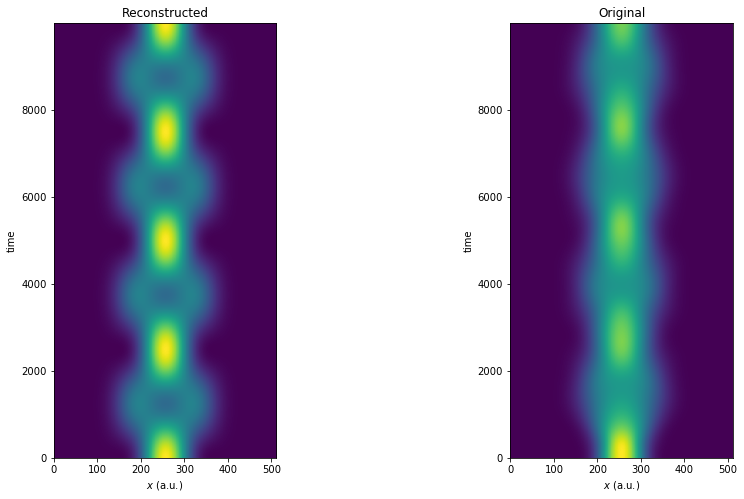

In [169]:
plt.subplot(121)

plt.title('Reconstructed')
plt.imshow(np.abs(reconstructed_wavefunctions) ** 2, origin='lower', aspect=0.1)

plt.xlabel('$x$ (a.u.)')
plt.ylabel('time')

plt.subplot(122)
plt.title('Original')
plt.imshow(np.abs(wavefunctions) ** 2, origin='lower', aspect=0.1)

plt.xlabel('$x$ (a.u.)')
plt.ylabel('time')

plt.show()

In [170]:
from scipy import fftpack, linalg
from scipy.signal import find_peaks, blackman


def test(wavefunctions, dt, threshold=1e-5, **kwargs):
        # normalize the wavefunction over the first axis (basis)
        wavefunctions /= linalg.norm(wavefunctions, axis=1)[:, np.newaxis]

        # calculate the auto correlation function
        auto_corr = wavefunctions @ wavefunctions[0].conj()

        # calculate the alternating sequence of signs for iFFT autocorrelation function
        k = np.arange(wavefunctions.shape[0])
        minus = (-1) ** k

        # energy axis (as prescribed by Method 1 for calculating Fourier transform
        energy_range = (k - k.size / 2) * np.pi / (0.5 * dt * k.size)

        # the windowed fft of the auto correlation function
        auto_corr_fft_w = np.abs(
            fftpack.ifft(minus * auto_corr * blackman(auto_corr.size), overwrite_x=True)
        )

        # normalize the auto correlation function
        auto_corr_fft_w /= auto_corr_fft_w.max()

        # extract peaks in the auto correlation function to get the eigen energies
        peaks, _ = find_peaks(auto_corr_fft_w, height=threshold, **kwargs)

        # the eigenvalues of the Hamiltonian
        energies = energy_range[peaks]
        
        
        plt.semilogy(energy_range, auto_corr_fft_w)        

        # draw vertical lines depicting the exact energies
        for ee in energies:
            plt.axvline(ee, linestyle='--', color='black')

        plt.xlim([-10., 10.])
        plt.show()

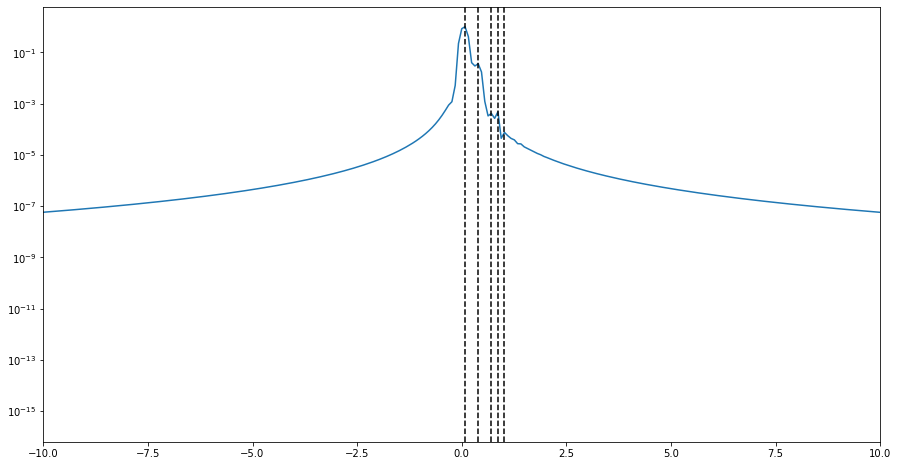

In [171]:
test(wavefunctions, quant_sys.dt)


In [172]:
reconstructed_h.energies

array([0.07853982, 0.39269908])